In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import *
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

## Synthetic Data

In this experiment we generate our own synthetically made data in order to test our diffusion-NMF algorithm. Specifically we create an X,V, and K to multiply together to give our synthetically made D (dataset)

As a first example here is how I might generate a synthetic X and V with shape 250 x 50 and rank 4. Also included is generation of a random graph + generation of diffusion with beta parameter equal to 1. Here X is just a set of sine waves that differ in period and amplitude. V is simply a (k x n) sparse matrix with a few non-zero coefficients to represent origin points or centers of diffusion

In [5]:
# defined parameters for data
n = 250
m = 50
rank = 4
rand_state = 1729

In [6]:
# because of naming conventions we use W,H instead of X,V here so that those variable names can be used later
# for all intents and purposes W,H is the same thing
W,H = gen_decomposition(n,m,rank,state=rand_state)

Text(445.23636363636354, 0.5, 'Basis')

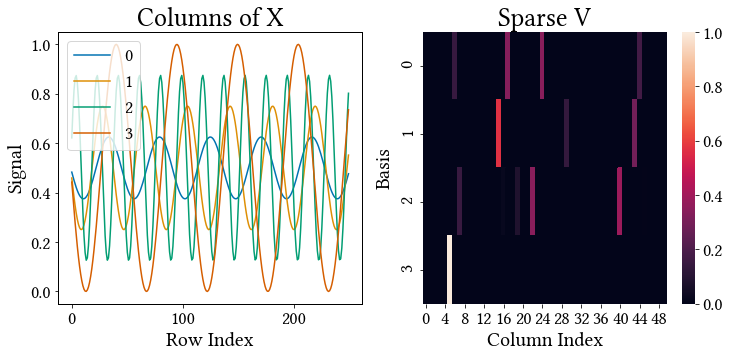

In [7]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
W.plot(ax=ax[0])
ax[0].set_title("Columns of X", fontsize = 26)
ax[0].set_xlabel("Row Index", fontsize = 20)
ax[0].set_ylabel("Signal", fontsize = 20)
sns.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Sparse V", fontsize = 26)
ax[1].set_xlabel("Column Index", fontsize = 20)
ax[1].set_ylabel("Basis", fontsize = 20)

In [8]:
# Laplacian:
G, lapl = gen_laplacian(size = m, radius = 0.30, state = rand_state)

# Diffusion Kernel
beta = 5
I = np.identity(np.dot(W,H).shape[1])
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H,K))

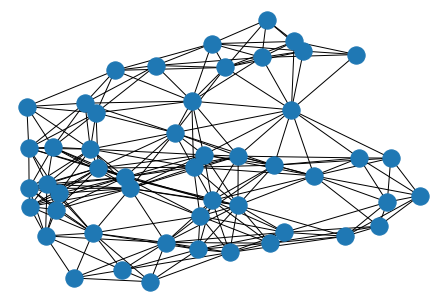

In [9]:
nx.draw(G)

The next requirement is to make K, the diffusion matrix given as input. For our purposes we chose to use a regularized laplacian kernel. Therefore we will always need a graph over which diffusion happens to use as input. Specifically in this example, we genereate a random geometric graph, compute its laplacian form (D (Diagonal degree matrix) - A (Adjacency matrix)), and create a kernel using a chosen beta value -- (I + beta * laplacian)^-1. Note that here and in our paper we chose a beta value of 5. 

Text(0.5, 1.0, 'Subset of generated data')

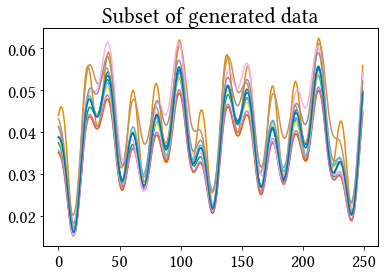

In [10]:
pd.DataFrame(D).loc[:,10:20].plot(legend=False)
plt.title("Subset of generated data")

After generating X,V, and K we take their product to satisfy the formula D = XVK. A subset of the D matrix is shown in the figure above. From this we will try to recover the X and V that we generated using the D-NMF algorithm with the generated K as input.

## Initial Test

Without any modification to the data, and knowing the true parameter, how well can NMF and diffusion-NMF recover the original X and V??

In [11]:
# NMF test
nmfer = nmf(n_components = 4, mask = None, n_iter = 100000, tol = 1e-9)
W_out, H_out = nmfer.fit_transform(D)

Text(0.5, 1.0, 'NMF reconstructed V')

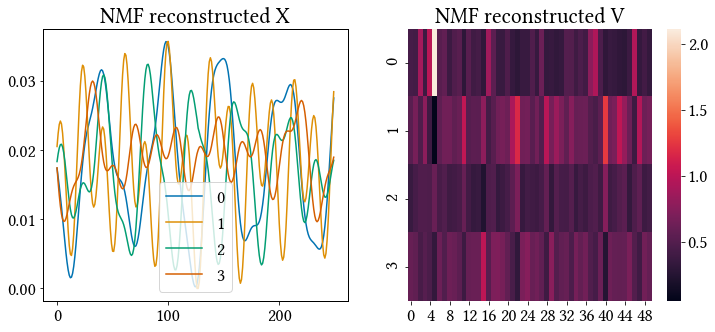

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(W_out).plot(title = "NMF reconstructed X", ax = ax[0])
sns.heatmap(H_out, square = False, cbar = True, ax = ax[1])
ax[1].set_title("NMF reconstructed V")

Standard NMF does okay in recovering the original X (wave) matrix. Some of the waves still seem to capture the essence of a sin wave, but things look a lot messier. What's more is that the coefficient matrix, V, outputted is not very sparse and does not seem to distinguish locations. Whereas our original V matrix highlighted only a few locations as sources of spread, this output matrix is gives coefficients which are hard to distinguish between.

**Note that columns/rows of W,H are out of order from what's seen in the original X,V above**

In [13]:
# diffusion NMF test
differ = diff_nmf(n_components = 4, kernel = K, mask = None, n_iter = 100000, tol = 1e-9)
X,V = differ.fit_transform(D)

Max iterations reached, increase to converge on given tolerance


Text(0.5, 1.0, 'D-NMF reconstructed V')

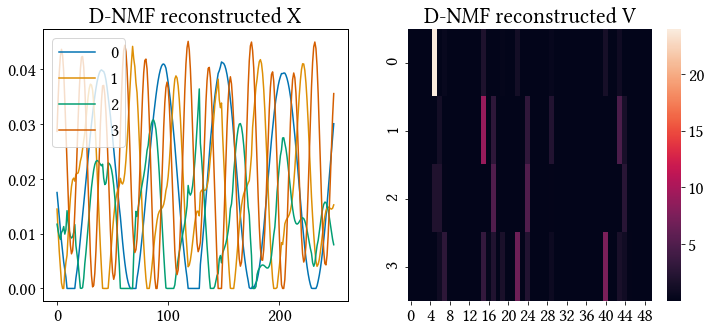

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(X).plot(title = "D-NMF reconstructed X", ax = ax[0])
sns.heatmap(V, square = False, cbar = True, ax = ax[1])
ax[1].set_title("D-NMF reconstructed V")

Here, diffusion NMF is again okay at capturing the original waves. It may do a bit better than NMF, but this is difficult to quantify or observe. However, Diffusion NMF excels at distinguishing a sparse set of origin points in the coefficient matrix V. This output matrix (though rows are out of order) is nearly identical to the one we had generated. 

**Again, columns/rows are out of order from what's seen in the original X,V above**

## Data modifications

In order to make the test setting more realistic and to avoid overfitting, I will modify the generated data as follows:

1. Randomly add noise to entries in the data to simulate noisy real-world data
2. Hide entries for a train/test procedure so as to avoid an overly fit solution

Please look to documentation in data_generator.py for more information on how this is done.

Text(0.5, 1.0, 'Subset of Data with Noise added')

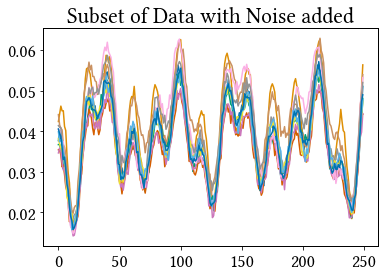

In [15]:
# Add noise
noise_D = add_noise(D, 0.001)
pd.DataFrame(noise_D).loc[:,10:20].plot(legend=False)
plt.title("Subset of Data with Noise added")

Note that when adding noise to the data we also add a small amount of error or difference between this noisy data and the original, generated data. This error will be helpful in the next experiment where we will use it as a baseline that gives more meaning to the error that we will see. 

In [16]:
# Hide Entries
hidden_mask = train_mask(noise_D, 0.2)

## Error Baseline

Now with these processes for creating test-ready data, I can analyze how both NMF and D-NMF perform as the parameters (rank and beta (spread parameter)) used for solving are changed. To be clear, I had used a pre-defined rank parameter (with value of 4) to generate the X matrix, and a pre-defined beta parameter (with value of 5) to generate the K matrix (diffusion kernel). Now we are testing to see how the algorithm performs over many different combinations of input parameters (which are not necessarily correct). To do so I will try many possible combinations of (rank, beta), analyzye the relative errors associated with their solution, and compare them with the baseline error that comes from adding noise to the data. 

In [24]:
# this function simply repeats the process of randomly adding noise / hiding entries for a range of tests
# it serves to compute the ground, baseline error that comes from simply adding noise.

def ground_error(data, tests, n_avg = 10, noise_base = 0.001, percent_hide = 0.2):
    ground_error = np.zeros(tests)
    ground_std = np.zeros(tests)
    
    for t in range(tests):
        g_err = np.zeros(n_avg)
        for n in range(n_avg):
            noise_D = add_noise(data, noise_base)
            hidden_mask = train_mask(noise_D, 0.2)
            g_err[n] = np.linalg.norm((1 - hidden_mask) * (noise_D - data)) / np.linalg.norm((1 - hidden_mask) * data)
            
        ground_error[t] = g_err.mean()
        ground_std[t] = g_err.std()
        
    return ground_error, ground_std

In [25]:
# Holding the true rank at 4 we can compute the error results for ground error, nmf error, and d-nmf error 
# using a range of changing rank parameters. For this experiment all beta parameters used are equal to the true
# value of 1.

noise_base = 0.001
ranks = list(range(1,15))
betas = np.array([5])
n_avg = 10

ground, ground_std = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  7.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 17.4min finished


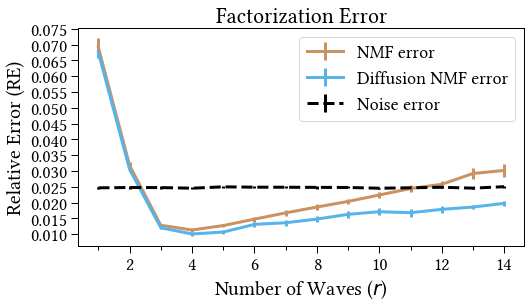

In [26]:
ranks = list(range(1,15))
c_pal = sns.color_palette("colorblind", 10)
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, nmf_res["relative error"], nmf_res["std error"], label = "NMF error", linewidth = 3, color = c_pal[5])
ax.errorbar(ranks, diff_res["relative error"], diff_res["std error"], label = "Diffusion NMF error", linewidth = 3, color = c_pal[9])
ax.errorbar(ranks, ground, ground_std, color = "k", linestyle = "--", label = "Noise error", linewidth = 3)
ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 20)
ax.set_ylabel("Relative Error (RE)", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend() 


First, we test how error changes as ONLY the rank parameter changes. The beta (spread) parameter is held at a constant, true value of 5. We see that as r approaches the true value of 4, error decreases rapidly from the left, and increases steadily as it continues to grow past it. This gives us good indication that visualizing error plots can be a nice way to recover the correct rank parameter. Note that for both NMF and D-NMF, the errors in the correct region are significantly smaller than the error that comes from only adding noise to the original data. Please note that the noisy data IS given as input to both NMF and D-NMF here, but both NMF and D-NMF are resilient in the sense that they can see past noise to the real trends in the data.

In [27]:
# Same thing but now testing beta values and holding true rank at 4:
ranks = [4]
#betas = np.linspace(0.1,2,15)
betas = np.linspace(0,10,20)
n_avg = 10

ground2, ground_std2 = ground_error(D, len(betas), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res2 = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res2 = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 21.8min finished


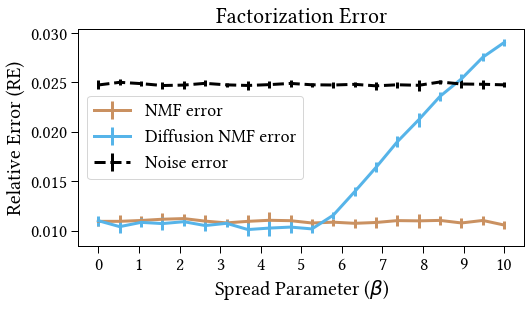

In [28]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(betas, nmf_res2["relative error"], nmf_res2["std error"], label = "NMF error", linewidth = 3, color = c_pal[5])
ax.errorbar(betas, diff_res2["relative error"], nmf_res2["std error"], label = "Diffusion NMF error", linewidth = 3, color = c_pal[9])
ax.errorbar(betas, ground2, ground_std2, color = "k", linestyle = "--", label = "Noise error", linewidth = 3)
ax.set_xlabel(r"Spread Parameter ($\beta$)", fontsize = 20)
ax.set_ylabel("Relative Error (RE)", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend()

Next, we test how error changes as ONLY the beta (spread) parameter changes. The rank parameter is held at a constant, true value of 4. We see that as beta approaches the true value of 5 from the left it is consistently low in error and comparable with NMF (NOTE that NMF has error which is consistently low throughout because beta is not a parameter of use within NMF. I.e. nothing is changing for NMF, it has its correct rank parameter already). However, almost immediately after passing 5 the error starts to increase linearly. This again is a solid indication that visualizing error plots can be a nice way to recover the correct beta parameter. Note that for both NMF and D-NMF, the errors in the correct region are significantly smaller than the error that comes from only adding noise to the original data. Please note that the noisy data IS given as input to both NMF and D-NMF here, but both NMF and D-NMF are resilient in the sense that they can see past noise to the real trends in the data.

## Grid Search for parameters

To extend the previous analysis I could also jointly search for the correct rank, beta parameters. Doing so would only require I use the same functions used in the previous example. Please look to grid_search.py for more information. Because the grid search process is quite expensive and the previous section covered how to use the functions, I will only show images of what the outcomes look like and leave the heavy lifting to a more powerful computer.

In [30]:
grid_data = pd.read_csv("synthetic_grid_search.csv")

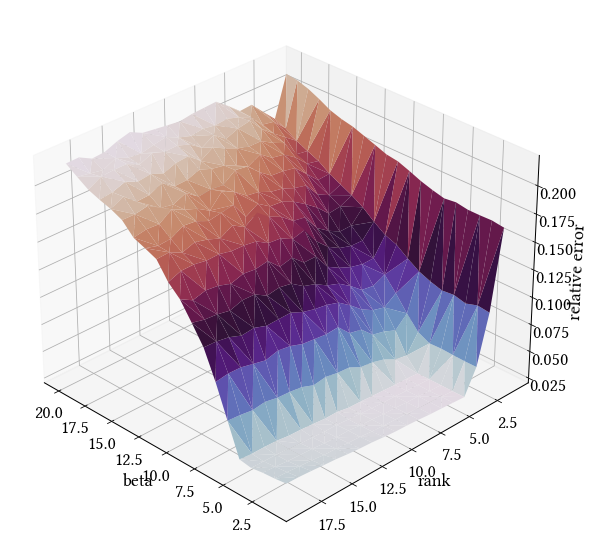

In [31]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_data['beta'], grid_data['rank'], grid_data['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,135)

Looking at the point (rank = 4, beta = 5) in the graph we can see that it sits in a nice corner and that error seems to take a minimal value there. Our hope has been to see something similar when analyzing real data. This "corner" gives a good indication of what the real parameter values are.